<a href="https://colab.research.google.com/github/josenomberto/UTEC-CDIAV3-MISTI/blob/main/day7_transformers_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**If you haven't already, please hit :**

`File` -> `Save a Copy in Drive`

**to copy this notebook to your Google drive, and work on a copy. If you don't do this, your changes won't be saved!**


# Introduction to Transformers

This notebook, modified from the Kaggle tutorial [Transformers from Scratch - DL](https://www.kaggle.com/code/auxeno/transformers-from-scratch-dl/notebook?scriptVersionId=137372275), is a step-by-step implementation of the transformer architecture from the seminal paper Attention Is All You Need https://arxiv.org/abs/1706.03762. We're only going to build the ***encoder block***, which correponds to the left side of the diagram.

<img src="https://i.imgur.com/Iv0MBNZ.png"
     width="350"
     caption="Full Transformer Architecture"/>

## Introduction


<img src="https://i.imgur.com/mZRlDQP.png"
     align="right"
     width="300" />
     
## The Encoder Only Architecture
     
The encoder on architecture has the following components:
1. **Input embedding**: An embedding layer, where a tokenized input sequence is represented as a sequence of embedding vectors.
2. **Positional encoding**: Provide the transformer with information about the position if each word in the sequence.
3. **Multi-head self-attention**: The key component of the transformer. Builds on the concept of attention in RNNs from Bahdanau, Cho and Bengio 2014 https://arxiv.org/abs/1409.0473.
4. **Residual connections and layer normalization**: Residual connections and layer normalization are applied multiple times in the transformer architecture. Residual connections came from He et al 2015 https://arxiv.org/abs/1512.03385 and layer normalization is considered to be an improvement on batch normalization, published in 2016 by Ba, Kiros and Hinton https://arxiv.org/abs/1607.06450.
5. **Feed forward**: A special version of a 2 layer feed-forward neural network
6. **Linear and softmax**: After applying layer normalization and skip connections a second time, our output is passed through a classification head consisting of one dense layer with a softmax output.
7. **Output probabilities**: Our classification head outputs a probability distribution of our input belonging to each class.

#Tokenization
Before we start working on our transformer architecture, we must first tokenize our text sequences.

We're going to use subword tokenization, specifically WordPiece, which is used by the BERT and DistilBERT tokenizers.

We will load the tokenizer from the Hugging Face Transformers library. Feel free to review this code to understand how tokenizers and word embeddings work

In [ ]:
import pandas as pd
from transformers import AutoTokenizer

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
text = 'Tokenizing text is a core concept in NLP.'

tokenized_text = {}
tokenized_text['Numerical Token'] = tokenizer(text)['input_ids']
tokenized_text['Token'] = tokenizer.convert_ids_to_tokens(tokenizer(text)['input_ids'])

print("Tokenizer has a vocabulary size of", tokenizer.vocab_size, "words.")
print("Tokenizer has a maximum sequence length of", tokenizer.model_max_length, "tokens.")
print("\nOur text to tokenize:", text, "\n")
pd.DataFrame(tokenized_text).T.style

Tokenizer has a vocabulary size of 30522 words.
Tokenizer has a maximum sequence length of 512 tokens.

Our text to tokenize: Tokenizing text is a core concept in NLP. 



,0,1,2,3,4,5,6,7,8,9,10,11,12
Numerical Token,101,19204,6026,3793,2003,1037,4563,4145,1999,17953,2361,1012,102
Token,[CLS],token,##izing,text,is,a,core,concept,in,nl,##p,.,[SEP]


#### Remarks:
- `[CLS]` Stands for *classifier* and indicates the start of a sequence.
- `[SEP]` Stands for *separate segment* and typically indicates the end of a sequence.
- We can see that 'Tokenizing' and 'NLP' have had their casing changed to lower, and both words have been split into 'token' + 'izing' and 'nl' + 'p'.
- The numerical indices each correspond to a word in the tokenizer's dictionary.

We're also going to create a sample text string that we'll pass through our network piece by piece, to ensure everything is working as intended:

In [ ]:
import torch

sample_text = "We're going to reduce the maximum sequence length to 100 tokens, \
so we'll use a longer string here for demonstration purposes. We're not going to \
reach the full 100 tokens, so we'll pad our sequence with 0s."

input_sequence = tokenizer.encode_plus(sample_text, return_tensors='pt', padding='max_length', truncation=True, max_length=100)['input_ids']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_sequence = input_sequence.to(device)

print(input_sequence)
print("\nShape of output:", input_sequence.shape)

tensor([[  101,  2057,  1005,  2128,  2183,  2000,  5547,  1996,  4555,  5537,
          3091,  2000,  2531, 19204,  2015,  1010,  2061,  2057,  1005,  2222,
          2224,  1037,  2936,  5164,  2182,  2005, 10467,  5682,  1012,  2057,
          1005,  2128,  2025,  2183,  2000,  3362,  1996,  2440,  2531, 19204,
          2015,  1010,  2061,  2057,  1005,  2222, 11687,  2256,  5537,  2007,
          1014,  2015,  1012,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]],
       device='cuda:0')

Shape of output: torch.Size([1, 100])


#Input Embedding

<img src="https://i.imgur.com/h9XnkhD.png"
     align="right"
     width="175" />

Our transformer architecture starts off with an embedding layer, where we represent each word as a vector in an embedding space.

### Implementing an Embedding Layer in PyTorch
We initialize our config dictionary which we will use throughout the program to define the parameters of our model.

In [ ]:
# Making a lightweight config class that allows for struct like attribute accessing
class Config:
    def __init__(self, config_dict):
        self.__dict__.update(config_dict)

# Setting parameters for our model
config = {# We get the vocabulary size used by our tokenizer
          'vocab_size': tokenizer.vocab_size,

          # We will use 128 dimensional token embeddings initially
          'embedding_dimensions': 128,

          # We're only going to use a maximum of 100 tokens per input sequence
          'max_tokens': 100,

          # Number of attention heads to be used
          'num_attention_heads': 8,

          # Dropout on feed-forward network
          'hidden_dropout_prob': 0.3,

          # Number of neurons in the intermediate hidden layer (quadruple the number of emb dims)
          'intermediate_size': 128 * 4,

          # How many encoder blocks to use in our architecture
          'num_encoder_layers': 2,

          # Device
          'device': device

}
# Wrapping our config dict with the lightweight class
config = Config(config)

In [ ]:
import torch.nn as nn

class TokenEmbedding(nn.Module):
    def __init__(self, config):
        super().__init__()
        # Create an embedding layer, with ~32,000 possible embeddings, each having 128 dimensions
        self.token_embedding = nn.Embedding(num_embeddings=config.vocab_size, embedding_dim=config.embedding_dimensions)

    def forward(self, tokenized_sentence):
        return self.token_embedding(tokenized_sentence)

token_embedding = TokenEmbedding(config).to(config.device)
embedding_output = token_embedding(input_sequence)
print("Shape of output:", embedding_output.size())

Shape of output: torch.Size([1, 100, 128])


#### Remarks:
- Our embedding layer ouputs a tensor of shape `[batch_size, seq_length, embedding_dims]`, which is what we expected.

Next we will add the positional encodings to our embeddings:

---



# EXERCISE: Positional Encodings

<img src="https://i.imgur.com/jCnm8lE.png"
     align="right"
     width="175" />

Since transformers inherently lack information about the order of an input sequence, positional encodings provide the transformer model with information about the position of words within a sentence. They serve as a "fingerprint" that enables the transformer to identify the true position of each word.



## TASK 1: Calculating Positional Encodings

In 'Attention is all you need' , positional encodings are calculated with the following formulae:

$$PE(position, i) = sin \left( \frac{position}{10000^{\frac{i}{d_{model}}}}\right) \textrm{for even i}$$
$$PE(position, i) = cos \left( \frac{position}{10000^{\frac{i-1}{d_{model}}}}\right) \textrm{for odd i}$$

Here, $i$ is the dimension and $d_{model}$ is the total number of dimensions in the token embedding. $position$ denotes the position of the word in the sentence.

The choice of sine and cosine functions is strategic, as these trigonometric functions produce values within the range of -1 to 1, which align well with the requirements of neural network inputs. Additionally their periodicity allows for easy extrapolation for sentences of varying lengths.

In [ ]:
# TASK 1 EXERCISE
import numpy as np
import matplotlib.pyplot as plt

# Number of possible positions (sequence length)
pos = config.max_tokens

# Number of latent space dimensions
d_model = config.embedding_dimensions

# Initialize matrix for positional encoding
pe = np.zeros((pos, d_model))

# Calculate positional encoding
for pos in range(pos):
    for i in range(0, d_model, 2):
      # Calculate PE for even i with np.sin
      pe[pos, i] = ''' ADD YOUR CODE HERE '''

      # Calculate PE for odd i with np.cos
      if i + 1 < d_model:
      pe[pos, i + 1] = ''' ADD YOUR CODE HERE '''


# Display as a heatmap
plt.figure(figsize=(10,6))
plt.imshow(pe, cmap='coolwarm_r')
plt.colorbar()
plt.xlabel('Dimension')
plt.ylabel('Position in Sequence')
plt.title('Positional Encoding Heatmap')

plt.show()

128


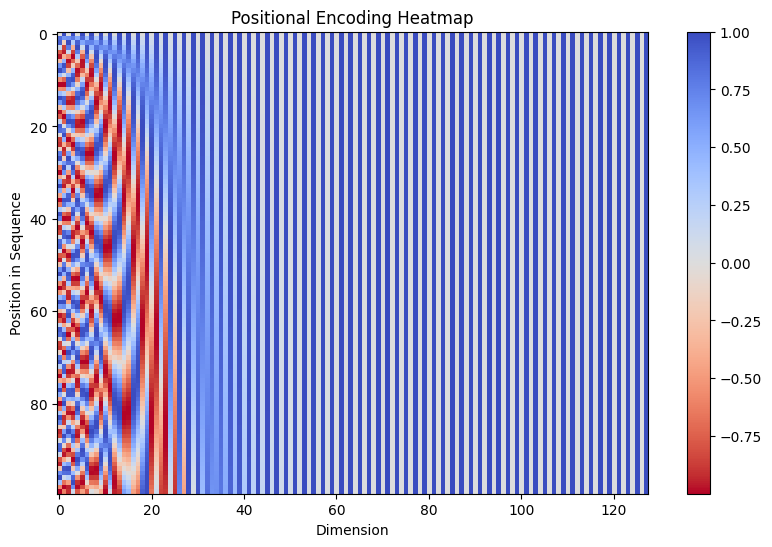

In [ ]:
# TASK 1 SOLUTION
import numpy as np
import matplotlib.pyplot as plt

# Number of possible positions (sequence length)
pos = config.max_tokens

# Number of latent space dimensions
d_model = config.embedding_dimensions

# Initialize matrix for positional encoding
pe = np.zeros((pos, d_model))

# Calculate positional encoding
for pos in range(pos):
    for i in range(0, d_model, 2):
        # Calculate PE for even i with np.sin
        pe[pos, i] = np.sin(pos / (10000 ** ((2 * i) / d_model)))
        # Calculate PE for odd i with np.cos
        if i + 1 < d_model:
            pe[pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1)) / d_model)))

# Display as a heatmap
plt.figure(figsize=(10,6))
plt.imshow(pe, cmap='coolwarm_r')
plt.colorbar()
plt.xlabel('Dimension')
plt.ylabel('Position in Sequence')
plt.title('Positional Encoding Heatmap')

plt.show()

### Implementing Positional Encodings in PyTorch
Run this code to implement positional encodings for our Transformer architecture

In [ ]:
# @title
class PositionalEncoding(nn.Module):
    def __init__(self, config):
        super().__init__()
        pe = torch.zeros(config.max_tokens, config.embedding_dimensions)
        position = torch.arange(0, config.max_tokens, dtype=torch.float).unsqueeze(1)
        div_term = 1 / (10000 ** (torch.arange(0, config.embedding_dimensions, 2).float() / config.embedding_dimensions))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.pe = pe.unsqueeze(0).transpose(0, 1)
        self.pe = self.pe.to(config.device)

    def forward(self, x):
        return x + self.pe[:, 0]


# Confirm this module is working as intended
positional_encoding = PositionalEncoding(config).to(config.device)
pos_enc_output = positional_encoding(embedding_output)
print("Shape of output:", pos_enc_output.size())

# View the difference between the two layers
# These differences can be checked with our heatmap visualization
diff = pos_enc_output - embedding_output
print("\nTensor at position 0 first 20 values:")
print(diff[0,0][:20])
print("\nTensor at position 0 last 20 values:")
print(diff[0,0][-20:])

print("\nTensor at position 50 first 20 values:")
print(diff[0,50][:20])
print("\nTensor at position 50 last 20 values:")
print(diff[0,50][-20:])

Shape of output: torch.Size([1, 100, 128])

Tensor at position 0 first 20 values:
tensor([0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000,
        1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000,
        0.0000, 1.0000], device='cuda:0', grad_fn=<SliceBackward0>)

Tensor at position 0 last 20 values:
tensor([0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000,
        1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000,
        0.0000, 1.0000], device='cuda:0', grad_fn=<SliceBackward0>)

Tensor at position 50 first 20 values:
tensor([-0.2624,  0.9650, -0.6320,  0.7750, -0.2030,  0.9792,  0.8690,  0.4948,
         0.1566, -0.9877, -0.7064,  0.7078,  0.7872, -0.6166, -0.5571,  0.8305,
        -0.1032, -0.9947,  0.9026,  0.4305], device='cuda:0',
       grad_fn=<SliceBackward0>)

Tensor at position 50 last 20 values:
tensor([0.0211, 0.9998, 0.0183, 0.9998, 0.0158, 0.9999, 0.0137, 0.9999, 0.0119,
        0.

# EXERCISE: Attention

<img src="https://i.imgur.com/hsH3PKz.png"
     align="right"
     width="175" />

Whilst not literally being 'all you need', multi-headed self-attention is probably the most revolutionary feature that came from transformers, so let's explore what it is.



## Self-Attention
For each position in the sequence, the self-attention mechanism computes relevance scores with all other positions in the same sequence. This allows each position to be updated based on all other positions.

Self-attention operates on all positions of the sequence simultaneously, making it highly *parallelizable* and more efficient on modern hardware accelerators. Each position in the sequence can be updated independently of the others, making self-attention a natural fit for 'transformer'-style models that avoid recurrent computations.

## Query Key and Value Vectors
During the computation of attention weights, we first project our token embedding vectors into three new vectors, called *query, key and value*.

Each embedding vector will have its own associated query, key and value vectors associated with it.

- **Query Vectors**: the "question" being asked. When we want to pay attention to specific information in the context, we do so in relation to a particular query.

- **Key Vectors**: the "address" in the memory that matches a given query. These keys are compared with the query to determine how much attention should be paid to their corresponding values.

- **Value Vectors**: the actual "content" in the memory that we want to focus on or retrieve.



##TASK 1: Implementing Self-Attention
1. Scaled dot product attention: A helper function that scales the value by the dot product of the query and key using Torch matrix operations.

$$
Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V
$$
where
- $Q,K,V \in n \times d_k$

  Note that the query, key, and value vectors are also indexed by batch. $d_k$ is the embedding dimension and $n$ is the input sequence length.

2. Attention head: A single attention head class.

In [ ]:
# TASK 1 EXERCISE
import torch.nn.functional as F

def scaled_dot_product_attention(query, key, value):
    b, n, d_k = query.size()
    # Compute attention scores
    attn_scores = ''' ADD YOUR CODE HERE ''' # (b,n,d_k) @ (b,d_k,n) ->  (b,n,n)

    # Apply softmax (F.softmax) to attention scores
    attn_weights = ''' ADD YOUR CODE HERE ''' # (b,n,n)

    # weighted aggregation
    attn_output = ''' ADD YOUR CODE HERE ''' # (b,n,n) @ (b,n,d_k) -> (b,n,d_k)

    return attn_output

class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)

    def forward(self, hidden_state):
        attn_outputs = scaled_dot_product_attention(self.q(hidden_state),
                                                    self.k(hidden_state),
                                                    self.v(hidden_state))
        return attn_outputs

# Example usage
batch, seq_length, d_model = 2, 4, 8
X_np = np.random.randn(batch, seq_length, d_model)

# Convert NumPy arrays to PyTorch tensors
Q = torch.from_numpy(X_np).float()
K = torch.from_numpy(X_np).float()
V = torch.from_numpy(X_np).float()

output = scaled_dot_product_attention(Q, K, V)
print("Self-Attention Output Shape:", output.shape)

In [ ]:
# TASK 1 SOLUTION
import torch.nn.functional as F

def scaled_dot_product_attention(query, key, value):
    b, n, d_k = query.size()
    # Compute attention scores
    # Note: you can also use torch.bmm
    attn_scores = query @ key.transpose(2,1) / np.sqrt(d_k) # (b,n,d_k) @ (b,d_k,n) ->  (b,n,n)

    # Apply softmax (F.softmax) to attention scores
    attn_weights = F.softmax(attn_scores, dim = -1) # (b,n,n)

    # weighted aggregation
    attn_output = attn_weights @ value # (b,n,n) @ (b,n,d_k) -> (b,n,d_k)

    return attn_output

class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)

    def forward(self, hidden_state):
        attn_outputs = scaled_dot_product_attention(self.q(hidden_state),
                                                    self.k(hidden_state),
                                                    self.v(hidden_state))
        return attn_outputs

# Example usage
batch, seq_length, d_model = 2, 4, 8
X_np = np.random.randn(batch, seq_length, d_model)

# Convert NumPy arrays to PyTorch tensors
Q = torch.from_numpy(X_np).float()
K = torch.from_numpy(X_np).float()
V = torch.from_numpy(X_np).float()

output = scaled_dot_product_attention(Q, K, V)
print("Self-Attention Output Shape:", output.shape)

Self-Attention Output Shape: torch.Size([2, 4, 8])


## TASK 2: Multi-Head Self-Attention
Multi-head self-attention simply allows our model to use several of these self-attention heads at once. This allows the attention-heads to divide labor and learn to pay attention to different aspects of the sentence. This division of labor permits for a richer understanding of context in the sentence than using just a single head would.

Each for attention head $h$:
$$Z^h = Attention(Q^h, K^h, V^h) \in \mathbb{R}^{n \times d_k}$$


Multi-head self-attention involves concatanating all $H$ attention heads and applying an output linear layer:
$$MultiHead(X) = Concat(Z^1, \ldots, Z^h)W^O $$
where
- $W_O \in H*d_k \times d$
- $d_k$ is the dimension of the attention head space
- $d$ is the embedding dimension.

In the example below, $d = d_k$.

In [ ]:
# TASK 2 EXERCISE
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.embedding_dimensions
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        # Concatenate the attention heads together with torch.cat
        x = """ADD YOUR CODE HERE"""
        # Apply the output linear layer
        x = """ADD YOUR CODE HERE"""
        return x

multihead_attn = MultiHeadAttention(config).to(config.device)
atn_output = multihead_attn(pos_enc_output)
print("Shape of output:", atn_output.size())
print("Number of heads:", len(MultiHeadAttention(config).heads))
multihead_attn.heads[:2]

In [ ]:
# TASK 2 SOLUTION
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.embedding_dimensions
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        # Concatenate the attention heads together with torch.cat
        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
        # Apply the output linear layer
        x = self.output_linear(x)
        return x

multihead_attn = MultiHeadAttention(config).to(config.device)
atn_output = multihead_attn(pos_enc_output)
print("Shape of output:", atn_output.size())
print("Number of heads:", len(MultiHeadAttention(config).heads))
multihead_attn.heads[:2]

Shape of output: torch.Size([1, 100, 128])
Number of heads: 8


ModuleList(
  (0-1): 2 x AttentionHead(
    (q): Linear(in_features=128, out_features=16, bias=True)
    (k): Linear(in_features=128, out_features=16, bias=True)
    (v): Linear(in_features=128, out_features=16, bias=True)
  )
)

#### Remarks:
- The shape of our output must have 8 heads, each with 16 output features such that the concatenation of all sums to 128.

---

#EXERCISE: Residual Connections and Layer Normalization

The next step is to apply residual connections and layer normalization to our outputs. Let's look at both components.

<img src="https://i.imgur.com/Uipv4De.png"
     align="right"
     width="175" />

## Residual Connections
Residual connections, also known as skip or shortcut connections, allow gradients to flow directly through a few layers by having the original input added to the output of a block of layers.

Residual connections allow us to train deeper models by reducing the problem ofvanishing gradients. As the network gets deeper, gradients calculated during backpropagation become increasingly small, a problem known as *vanishing gradients*.

## Layer Normalization
Layer Normalization is a type of normalization technique, similar to Batch Normalization but with different properties.

The core idea of Layer Normalization is to normalize the values of each feature vector in a batch independently, making the average of their means and variances zero and one, respectively. The primary advantage of Layer Normalization is that it works independently of batch size. This is an important feature for Transformer models, which tend to use smaller batch sizes due to memory constraints.

## TASK 1: Residual Connections and Layer Normalization in Transformers

Each sub-layer in the Transformer (self-attention, point-wise feed-forward) has a residual connection around it followed by layer normalization. The output of each sub-layer is simply `LayerNorm(x + Sublayer(x))`, where Sublayer(x) is the function implemented by the sub-layer itself.#

In [ ]:
# TASK 1 EXERCISE
# First, we get our positional encoder output
x = pos_enc_output

# Instantiate the layer normalization
layer_norm = nn.LayerNorm(config.embedding_dimensions).to(config.device)

# Our output is then defined as the normalized output of the attention block
# plus the ouput of the positional encoder (skip connection)
add_norm_output = '''ADD YOUR CODE HERE'''

print("Shape of output:", add_norm_output.size())

In [ ]:
# TASK 1 SOLUTION
# First, we get our positional encoder output
x = pos_enc_output

# Instantiate the layer normalization
layer_norm = nn.LayerNorm(config.embedding_dimensions).to(config.device)

# Our output is then defined as the normalized output of the attention block
# plus the ouput of the positional encoder (skip connection)
add_norm_output = layer_norm(x + multihead_attn(x))

print("Shape of output:", add_norm_output.size())

Shape of output: torch.Size([1, 100, 128])


#EXERCISE: Feed-Forward Network

<img src="https://i.imgur.com/FxIFK65.png"
     align="right"
     width="175" />
     
The next component we encounter is the *Position-Wise* Feed-Forward Network (FFN), otherwise known as Multi-layer Perception (MLP).
The Feed-Forward Network in the Transformer takes the output of the attention mechanism (the context-enriched word representation) and applies further transformations to enable recognition of more complex patterns or features.

### TASK 1: Implementing the Feed-Forward Network in PyTorch
It consists of two fully connected layers, with a non-linear activation function in between, followed by a dropout layer to prevent overfitting. The activation function used in Attention is All You Need and in most transformer models is GELU (Gaussian Error Linear Units).

In [ ]:
# TASK 1 EXERCISE
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.linear_1 = nn.Linear(config.embedding_dimensions, config.intermediate_size)
        self.linear_2 = nn.Linear(config.intermediate_size, config.embedding_dimensions)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, x):
        """ADD YOUR CODE HERE"""

In [ ]:
# TASK 1 SOLUTION
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.linear_1 = nn.Linear(config.embedding_dimensions, config.intermediate_size)
        self.linear_2 = nn.Linear(config.intermediate_size, config.embedding_dimensions)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.linear_2(x)
        x = self.dropout(x)
        return x

#EXERCISE: Encoder Block

<img src="https://i.imgur.com/gYci9Lu.png"
     align="right"
     width="200" />

Now that we have implemented each piece of the encoder block, we can start assembling them together to form the encoder part of the Transformer architecture. To refresh, each encoder block is composed of the following components:

1. **Multi-head self-attention**: Allows each input to interact with every other input to figure out how they should be weighted or 'attended to'.
2. **Residual connections and layer normalization**: These techniques help to stabilize the learning process and mitigate the problem of vanishing/exploding gradients, which can occur in deep networks.
3. **Feed forward network**: A small, fully connected neural network that applies further transformations to the output of the self-attention mechanism. It refines the word representations by processing them individually.



##TASK 1: Implementing an Encoder Block
In Attention Is All You Need, the layer normalization configuration used is *post layer normalization*, whereby we place layer normalization in between the skip connections. This arrangement is tricky to train from scratch as the gradients can easily diverge. Instead we will use a slightly different variant called *pre layer normalization*, which is the most common variant found in transformer literature (Xiong et al. 2020 https://arxiv.org/abs/2002.04745).

<img src="https://i.imgur.com/lj5pme1.png"
     align="center"
     width="600" />

We're going to slightly diverge from Attention Is All You Need to utilize pre-LN.

In [ ]:
# TASK 1 EXERCISE
class PostLNEncoder(nn.Module):
    "The original architecture used in Attention Is All You Need"
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(config)
        self.layer_norm1 = nn.LayerNorm(config.embedding_dimensions)
        self.layer_norm2 = nn.LayerNorm(config.embedding_dimensions)
        self.feed_forward = FeedForward(config)

    def forward(self, x):
        # Layer normalization + skip connections over the self-attention block
        x = self.layer_norm1(x + self.attention(x))
        # Layer norm + skip connections over the FFN
        x = self.layer_norm2(x + self.feed_forward(x))
        return x

class Encoder(nn.Module):
    "The improved pre-LN architecture"
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(config)
        self.layer_norm1 = nn.LayerNorm(config.embedding_dimensions)
        self.layer_norm2 = nn.LayerNorm(config.embedding_dimensions)
        self.feed_forward = FeedForward(config)

    def forward(self, x):
        # First perform layer normalization
        hidden_state = """ADD YOUR CODE HERE"""

        # Then apply attention + skip connection
        x = """ADD YOUR CODE HERE"""

        # Apply layer normalization before inputting to the FFN
        hidden_state = """ADD YOUR CODE HERE"""

        # Apply FNN + skip connection
        x = """ADD YOUR CODE HERE"""
        return x


# Verify this all works with the ouput of the positional embeddings
# Initialize an encoder block
encoder = Encoder(config).to(config.device)

# Pass the output from the positional encoder to the encoder block
encoder_output = encoder(pos_enc_output)

print("Shape of output:", encoder_output.size())

Shape of output: torch.Size([1, 100, 128])


In [ ]:
# TASK 1 SOLUTION
class PostLNEncoder(nn.Module):
    "The original architecture used in Attention Is All You Need"
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(config)
        self.layer_norm1 = nn.LayerNorm(config.embedding_dimensions)
        self.layer_norm2 = nn.LayerNorm(config.embedding_dimensions)
        self.feed_forward = FeedForward(config)

    def forward(self, x):
        # Layer normalization + skip connections over the self-attention block
        x = self.layer_norm1(x + self.attention(x))
        # Layer norm + skip connections over the FFN
        x = self.layer_norm2(x + self.feed_forward(x))
        return x

class Encoder(nn.Module):
    "The improved pre-LN architecture"
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(config)
        self.layer_norm1 = nn.LayerNorm(config.embedding_dimensions)
        self.layer_norm2 = nn.LayerNorm(config.embedding_dimensions)
        self.feed_forward = FeedForward(config)

    def forward(self, x):
        # First perform layer normalization
        hidden_state = self.layer_norm1(x)
        # Then apply attention + skip connection
        x = x + self.attention(hidden_state)

        # Apply layer normalization before inputting to the FFN
        hidden_state = self.layer_norm2(x)
        # Apply FNN + skip connection
        x = x + self.feed_forward(hidden_state)
        return x


# Verify this all works with the ouput of the positional embeddings
# Initialize an encoder block
encoder = Encoder(config).to(config.device)

# Pass the output from the positional encoder to the encoder block
encoder_output = encoder(pos_enc_output)

print("Shape of output:", encoder_output.size())

#EXERCISE: Classifier Head
Since our transformer is a classifier, we finish off with a classifier head.

##TASK 1: Implementing the Classifier Head
Our classifier head first flattens the output of the encoder block, then passes it through two dense layers with ReLU activation in the middle. Since we're going to use this transformer for binary classification, we then pass our final output through a sigmoid activation function (with torch.sigmoid).

In [ ]:
#TASK 1 EXERCISE
class ClassifierHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(config.max_tokens * config.embedding_dimensions, 2 * config.embedding_dimensions)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(2 * config.embedding_dimensions, 1)

    def forward(self, x):
        """ADD YOUR CODE HERE"""

# Initialize a classifier head
classifier = ClassifierHead(config).to(config.device)

# Pass the output from the positional encoder to the encoder block
pred = classifier(encoder_output)

print("Shape of output:", pred.size())
print("Prediction:", pred.item())

In [ ]:
# TASK 1 SOLUTION
class ClassifierHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(config.max_tokens * config.embedding_dimensions, 2 * config.embedding_dimensions)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(2 * config.embedding_dimensions, 1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return torch.sigmoid(x) # Sigmoid activation for binary classification

# Initialize a classifier head
classifier = ClassifierHead(config).to(config.device)

# Pass the output from the positional encoder to the encoder block
pred = classifier(encoder_output)

print("Shape of output:", pred.size())
print("Prediction:", pred.item())

Shape of output: torch.Size([1, 1])
Prediction: 0.4753248393535614


#EXERCISE: The Full Transformer

<img src="https://i.imgur.com/iuyrnqm.png"
     align="right"
     width="240" />

Finally, with all the individual components of our transformer in place, it's time to assemble them. We have crafted each building block: the input embeddings, positional encodings, self-attention mechanisms, the feed-forward network, and the classification head.




##TASK 1: Assembling the Full Transformer

In [ ]:
# TASK 1 EXERCISE
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embedding = TokenEmbedding(config)
        self.positional_encoding = PositionalEncoding(config)
        self.encoders = nn.ModuleList([Encoder(config) for _ in range(config.num_encoder_layers)])
        self.classifier_head = ClassifierHead(config)

    def forward(self, x):
        """ADD YOUR CODE HERE"""



# Instantiate a full model
model = Transformer(config).to(config.device)

# Make a prediction from the input sequence described earlier
pred = model(input_sequence)
print("Prediction:", pred.item())

In [ ]:
# TASK 1 SOLUTION
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embedding = TokenEmbedding(config)
        self.positional_encoding = PositionalEncoding(config)
        self.encoders = nn.ModuleList([Encoder(config) for _ in range(config.num_encoder_layers)])
        self.classifier_head = ClassifierHead(config)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        for encoder in self.encoders:
            x = encoder(x)
        return self.classifier_head(x)

# Instantiate a full model
model = Transformer(config).to(config.device)

# Make a prediction from the input sequence described earlier
pred = model(input_sequence)
print("Prediction:", pred.item())

Prediction: 0.5883120894432068


#### Remarks:
Our output represents the probability of the input text sequence belonging to class 1.



#Training the Transformer
Now that we have our transformer ready, we need to train it on some real data. For this, we'll use a well-known dataset named 'Natural Language Processing with Disaster Tweets'.

The Disaster Tweets dataset is a compilation of 10,000 tweets that have been hand-classified. The tweets have been categorized into two classes: 'disaster' and 'non-disaster'. Our task is to train our Transformer to differentiate between the two based on the content of the tweet. This dataset is perfect for our purpose as it focuses solely on text data, and offers us a binary classification task to test our model.



## Loading the Data
First, we load our data. The dataset is already well organized and can be readily loaded into a Pandas DataFrame.

For our task, we're only interested in two fields: the 'text' and 'target'. The 'text' field contains the content of the tweet, which we'll use as our input, and the 'target' field contains the label (0 or 1), which will serve as our ground truth during training.

In [ ]:
# Install gdown for downloading files from Google Drive
!pip install gdown

In [ ]:
import gdown
import os

# Google Drive file IDs and desired filenames
train_file_id = '1sGE48PIJAOP3bn9VJTv2yGTgtka1RKMW'
train_filename = 'train.csv'
test_file_id = '1m3mBXPTdntucev2TBFD1EvdBomakLUAa'
test_filename = 'test.csv'

# Download the files
gdown.download(id=test_file_id, output=test_filename, quiet=False)
gdown.download(id=train_file_id, output=train_filename, quiet=False)

print(f"Downloaded {test_filename} to {os.getcwd()}")
print(f"Downloaded {train_filename} to {os.getcwd()}")

Downloading...
From: https://drive.google.com/uc?id=1m3mBXPTdntucev2TBFD1EvdBomakLUAa
To: /content/test.csv
100%|██████████| 421k/421k [00:00<00:00, 23.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sGE48PIJAOP3bn9VJTv2yGTgtka1RKMW
To: /content/train.csv
100%|██████████| 988k/988k [00:00<00:00, 29.8MB/s]

Downloaded test.csv to /content
Downloaded train.csv to /content


In [ ]:
train_path, test_path = 'train.csv', 'test.csv'
df = pd.read_csv(train_path, index_col=0, usecols=['id', 'text', 'target'])

print("Columns in train.csv:", df.columns.tolist())
df.head()

Columns in train.csv: ['text', 'target']


,text,target
id,,
1,Our Deeds are the Reason of this #earthquake M...,1
4,Forest fire near La Ronge Sask. Canada,1
5,All residents asked to 'shelter in place' are ...,1
6,"13,000 people receive #wildfires evacuation or...",1
7,Just got sent this photo from Ruby #Alaska as ...,1


### Splitting the Data: Training and Validation
To accurately gauge the performance of our model, we reserve a subset of our training data for validation. Here we will use an 80:20 training validation split.

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

## Initializing the Tokenizer
To process our text data, we initialize a preconfigured WordPiece tokenizer. This tokenizer converts our text data into a numerical format that can be interpreted by our model.

In [ ]:
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

text = train_df.iloc[42].text

tokenized_text = {}
tokenized_text['Numerical Token'] = tokenizer(text)['input_ids']
tokenized_text['Token'] = tokenizer.convert_ids_to_tokens(tokenizer(text)['input_ids'])

print("Tokenizer has a vocabulary size of", tokenizer.vocab_size, "words.")
print("Tokenizer has a maximum sequence length of", tokenizer.model_max_length, "tokens.\n")
print("Sample tweet:", text, "\n")
pd.DataFrame(tokenized_text).T.style

Tokenizer has a vocabulary size of 30522 words.
Tokenizer has a maximum sequence length of 512 tokens.

Sample tweet: USATODAY: On today's #frontpage: #Bioterror lab faced secret sanctions. #RickPerry doesn't make the cut for FoxNewÛ_ http://t.co/5uKOHk7SoB 



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
Numerical Token,101,3915,3406,10259,1024,2006,2651,1005,1055,1001,2392,13704,1024,1001,16012,3334,29165,6845,4320,3595,17147,1012,1001,6174,4842,2854,2987,1005,1056,2191,1996,3013,2005,4419,2638,16050,1035,8299,1024,1013,1013,1056,1012,2522,1013,1019,6968,11631,2243,2581,6499,2497,102
Token,[CLS],usa,##to,##day,:,on,today,',s,#,front,##page,:,#,bio,##ter,##ror,lab,faced,secret,sanctions,.,#,rick,##per,##ry,doesn,',t,make,the,cut,for,fox,##ne,##wu,_,http,:,/,/,t,.,co,/,5,##uk,##oh,##k,##7,##so,##b,[SEP]


### Tokenization: Converting Text to Numeric Sequences
Here we proceed to apply our tokenizer to the text data present in both the training and validation datasets. This process transforms each text string into a corresponding sequence of numeric tokens. To ensure uniformity, each sequence is set to have a maximum length of 100 tokens. Any sequences shorter than this length are backward padded with zeros.

In [ ]:
# We limit the maximum length to 100 per tweet
max_length = config.max_tokens

def tokenize_text(row, max_length):
    text = row['text']
    tokenized = tokenizer.encode_plus(text, padding='max_length', truncation=True, max_length=max_length)
    return tokenized['input_ids']

train_df['tokenized'] = train_df.apply(lambda row: tokenize_text(row, max_length), axis=1)
val_df['tokenized'] = val_df.apply(lambda row: tokenize_text(row, max_length), axis=1)


train_df.head()

,text,target,tokenized
id,,,
7128,Courageous and honest analysis of need to use ...,1,"[101, 26103, 1998, 7481, 4106, 1997, 2342, 200..."
4688,@ZachZaidman @670TheScore wld b a shame if tha...,0,"[101, 1030, 12397, 25290, 21804, 1030, 25535, ..."
6984,Tell @BarackObama to rescind medals of 'honor'...,1,"[101, 2425, 1030, 13857, 16429, 8067, 2000, 24..."
4103,Worried about how the CA drought might affect ...,1,"[101, 5191, 2055, 2129, 1996, 6187, 14734, 245..."
6706,@YoungHeroesID Lava Blast &amp; Power Red #Pan...,0,"[101, 1030, 2402, 5886, 22504, 3593, 13697, 84..."


## Preparing the Dataloaders
Next we leverage PyTorch's DataLoader utility. DataLoaders serve as efficient data pipelines that handle batching and shuffling of data, saving a significant amount of manual work.

In [ ]:
from torch.utils.data import Dataset, DataLoader

X_train = train_df['tokenized']
y_train = train_df['target']

X_val = val_df['tokenized']
y_val = val_df['target']

class TextDataset(Dataset):
    def __init__(self, x_dataframe, y_dataframe):
        self.x_dataframe = x_dataframe
        self.y_dataframe = y_dataframe

    def __len__(self):
        return len(self.x_dataframe)

    def __getitem__(self, idx):
        x = self.x_dataframe.iloc[idx]  # Get the 'tokenized' data
        y = self.y_dataframe.iloc[idx]  # Get the 'target' data
        return torch.LongTensor(x), torch.tensor(y, dtype=torch.float32)

# Create both datasets
train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)

# Create the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Shuffle for random sampling without replacement
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

## The Training Loop
At this stage, we're ready to train our model. First, we define our loss function and the optimizer. After moving our model to a GPU (if one is available), we commence the training over 8 epochs.

For monitoring purposes, we log our training and validation metrics every 20 batches. This data will allow us to visualize our model's performance dynamics over time.

In [ ]:
# Instantiate a transformer model
model = Transformer(config).to(config.device)

# Define loss function and optimizer
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Move model to GPU if available
model = model.to(config.device)

# Number of training epochs
n_epochs = 8

# Metrics dictionary for plotting later
metrics = {
    'train_loss': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_accuracy': [],
}

# Training loop
for epoch in range(n_epochs):
    for i, (inputs, targets) in enumerate(train_dataloader):

        # Move inputs and targets to device
        inputs = inputs.to(config.device)
        targets = targets.to(config.device)

        # Set model to training mode
        model.train()

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        train_loss = loss_function(outputs.squeeze(), targets)

        # Backward pass and optimize
        train_loss.backward()
        optimizer.step()

        # Calculate accuracy
        train_predictions = (outputs.squeeze().detach().cpu() > 0.5)
        train_accuracy = (train_predictions == targets.cpu()).type(torch.float).mean().item()

        # Validation loop
        if i % 20 == 0:
            model.eval()
            with torch.no_grad():
                val_losses = []
                val_accuracies = []

                for val_inputs, val_targets in val_dataloader:
                    val_inputs = val_inputs.to(config.device)
                    val_targets = val_targets.to(config.device)

                    val_outputs = model(val_inputs)
                    val_loss = loss_function(val_outputs.squeeze(), val_targets)
                    val_losses.append(val_loss.item())

                    val_predictions = (val_outputs.squeeze().detach().cpu() > 0.5)
                    val_accuracy = (val_predictions == val_targets.cpu()).type(torch.float).mean().item()
                    val_accuracies.append(val_accuracy)

            # Get the mean loss and accuracy over the validation set
            val_loss = np.mean(val_losses)
            val_accuracy = np.mean(val_accuracies)

            # Print metrics here during training
            print(f"Epoch {epoch+1}/{n_epochs} Step {i} \tTrain Loss: {train_loss.item():.2f} \tTrain Accuracy: {train_accuracy:.3f}\n\t\t\tVal Loss: {val_loss:.2f}   \tVal Accuracy: {val_accuracy:.3f}")

            # Store metrics
            metrics['train_loss'].append(train_loss.item())
            metrics['train_accuracy'].append(train_accuracy)
            metrics['val_loss'].append(val_loss)
            metrics['val_accuracy'].append(val_accuracy)

Epoch 1/8 Step 0 	Train Loss: 0.72 	Train Accuracy: 0.484
			Val Loss: 12.20   	Val Accuracy: 0.573
Epoch 1/8 Step 20 	Train Loss: 0.57 	Train Accuracy: 0.719
			Val Loss: 0.69   	Val Accuracy: 0.575
Epoch 1/8 Step 40 	Train Loss: 0.66 	Train Accuracy: 0.594
			Val Loss: 0.69   	Val Accuracy: 0.572
Epoch 1/8 Step 60 	Train Loss: 0.72 	Train Accuracy: 0.500
			Val Loss: 0.68   	Val Accuracy: 0.574
Epoch 1/8 Step 80 	Train Loss: 0.59 	Train Accuracy: 0.719
			Val Loss: 0.63   	Val Accuracy: 0.656
Epoch 2/8 Step 0 	Train Loss: 0.58 	Train Accuracy: 0.719
			Val Loss: 0.62   	Val Accuracy: 0.655
Epoch 2/8 Step 20 	Train Loss: 0.60 	Train Accuracy: 0.688
			Val Loss: 0.61   	Val Accuracy: 0.673
Epoch 2/8 Step 40 	Train Loss: 0.51 	Train Accuracy: 0.828
			Val Loss: 0.61   	Val Accuracy: 0.670
Epoch 2/8 Step 60 	Train Loss: 0.59 	Train Accuracy: 0.703
			Val Loss: 0.67   	Val Accuracy: 0.613
Epoch 2/8 Step 80 	Train Loss: 0.57 	Train Accuracy: 0.703
			Val Loss: 0.59   	Val Accuracy: 0.693
E

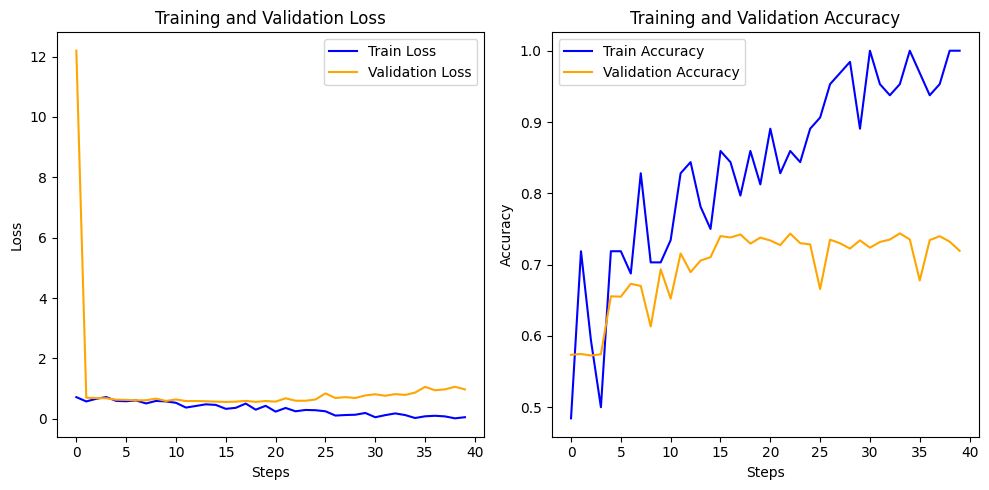

In [ ]:
# Set up the figure and axes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot the loss
ax[0].plot(metrics['train_loss'], color='blue', label='Train Loss')
ax[0].plot(metrics['val_loss'], color='orange', label='Validation Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Steps')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot the accuracy
ax[1].plot(metrics['train_accuracy'], color='blue', label='Train Accuracy')
ax[1].plot(metrics['val_accuracy'], color='orange', label='Validation Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Steps')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Display the figure
plt.tight_layout()
plt.show()